In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [3]:
bdif = pd.read_excel("bdif_modelo.xlsx")
bdif.head()

,parte,año,cod_com,cod_prov,probignicion,detectadopor,fecha,combustible,fuego,lugar,...,velmedia,racha,sol,hrmedia,fwi,denpoblacion,denincendios,horario,areaquemada,claseincendio
0,1974020249,1974,11,2,0.0,otros,1974-04-25,bosques,sup_cop,otros,...,6.1,11.900000,9.5,56.0,12.101361,0.041339,0.000020,Tarde,8.0,incendio
1,1974020374,1974,11,2,0.0,otros,1974-05-19,bosques,sup_cop,excursionistas,...,6.4,13.100000,10.9,53.0,69.039001,0.334612,0.000013,Tarde,0.3,conato
2,1974020459,1974,11,46,0.0,agente_forestal,1974-06-11,bosques,sup_cop,otros,...,3.6,11.100000,3.3,71.0,11.837668,0.084859,0.000022,Mañana,0.6,conato
3,1974022274,1974,11,2,0.0,otros,1974-09-11,bosques,sup_cop,autovia_carretera,...,5.0,7.116667,8.9,63.0,42.358257,0.139880,0.000123,Tarde,2.0,incendio
4,1974022457,1974,11,2,0.0,agente_forestal,1974-10-01,mat_bos,sup_cop,otros,...,4.7,14.400000,9.3,45.0,15.454229,0.035034,0.000068,Mañana,0.5,conato


In [4]:
# vamos a guardar el dataset cargado
bdif_save = bdif.copy()

In [4]:
#bdif = bdif_save.copy()

### Normalizamos las variables numéricas

In [5]:
# Seleccionamos las variables numéricas
numericas = ['probignicion', 'altitud', 'lon', 'lat', 'prec', 'tmax', 'dir', 'velmedia',
             'racha', 'sol', 'hrmedia', 'denpoblacion', 'denincendios', 'fwi']

# Cargamos el Standard Scaler
# scaler = StandardScaler()
scaler = MinMaxScaler()

bdif[numericas] = scaler.fit_transform(bdif[numericas])

# Mostramos el resultado
bdif[numericas].head()

,probignicion,altitud,lon,lat,prec,tmax,dir,velmedia,racha,sol,hrmedia,denpoblacion,denincendios,fwi
0,0.0,0.517710,0.703490,0.663822,0.0,0.462795,0.805556,0.194268,0.218750,0.637584,0.541667,0.000166,0.000014,0.068724
1,0.0,0.335891,0.731106,0.672918,0.0,0.637024,0.500000,0.203822,0.240809,0.731544,0.510417,0.001347,0.000006,0.421203
2,0.0,0.351240,0.760152,0.707177,0.0,0.571688,0.250000,0.114650,0.204044,0.221477,0.697917,0.000341,0.000018,0.067092
3,0.0,0.664109,0.699029,0.672143,0.0,0.662432,0.418981,0.159236,0.130821,0.597315,0.614583,0.000563,0.000145,0.256033
4,0.0,0.410272,0.714636,0.675420,0.0,0.575318,0.694444,0.149682,0.264706,0.624161,0.427083,0.000141,0.000076,0.089480


### Aplicamos one hot encoding a las variables categoricas

In [6]:
# Seleccionamos las variables categóricas
categoricas = ['detectadopor', 'combustible', 'fuego', 'lugar', 'mes', 'dia', 'horario']

# Generamos las variabes dummies
bdif = pd.get_dummies(bdif, columns=categoricas, drop_first=False)

# Las convertimos a 0 y 1
dummies = bdif.filter(regex='^detectadopor|^combustible|^fuego|^lugar|^mes|^dia|^horario').columns
bdif[dummies] = bdif[dummies].astype(int)

# Mostramos el resultado
bdif.head

<bound method NDFrame.head of              parte   año  cod_com  cod_prov  probignicion      fecha  \
0       1974020249  1974       11         2      0.000000 1974-04-25   
1       1974020374  1974       11         2      0.000000 1974-05-19   
2       1974020459  1974       11        46      0.000000 1974-06-11   
3       1974022274  1974       11         2      0.000000 1974-09-11   
4       1974022457  1974       11         2      0.000000 1974-10-01   
...            ...   ...      ...       ...           ...        ...   
570367  2016500122  2016       10        50      0.083157 2016-10-09   
570368  2016500123  2016       10        50      0.083157 2016-11-10   
570369  2016500124  2016       10        50      0.083157 2016-11-14   
570370  2016509001  2016       10        50      0.083157 2016-06-14   
570371  2016510001  2016       18        51      0.088889 2016-09-28   

           poblacion  superficie   altitud       lon  ...  mes_octubre  \
0        2117.457786  51221.680

### Aplicamos mapeo de clases a la variable objetivo

In [7]:
# Crear un diccionario para mapear las clases a valores específicos
mapeo_clases = {'conato': 0, 'incendio': 1, 'gif': 2}

# Aplicar el mapeo a la columna 'claseincendio'
bdif['claseincendio'] = bdif['claseincendio'].map(mapeo_clases)

# Verificar el resultado
bdif['claseincendio'].value_counts()

claseincendio
0    334211
1    234195
2      1966
Name: count, dtype: int64

### Submuestreo

In [10]:
# Dividir las clases mayoritarias y minoritaria
conatos = bdif[bdif['claseincendio'] == 0]
incendios = bdif[bdif['claseincendio'] == 1]
gif = bdif[bdif['claseincendio'] == 2]

# Submuestrear las clases mayoritarias
conatos_sub = resample(conatos, replace=False, n_samples=len(gif), random_state=42)

incendios_sub = resample(incendios, replace=False, n_samples=len(gif), random_state=42)

# Combina las clases balanceadas y la clase minoritaria
bdif_balanced = pd.concat([conatos_sub, incendios_sub, gif])

# Mostramos el balanceo
bdif_balanced['claseincendio'].value_counts()

claseincendio
0    1966
1    1966
2    1966
Name: count, dtype: int64

## Selección de características con una Regresión Logística

In [8]:
# Separamos las variables descriptivas y la variable objetivo
X = bdif.drop(['parte', 'año', 'cod_com', 'cod_prov', 'fecha', 'poblacion', 'superficie', 'areaquemada', 'claseincendio'], axis = 1)
y = bdif['claseincendio']

# Separamos las variables descriptivas y la variable objetivo con un dataset mas pequeño
#X = bdif_balanced.drop(['parte', 'año', 'cod_com', 'cod_prov', 'fecha', 'poblacion', 'superficie', 'areaquemada', 'claseincendio'], axis = 1)
#y = bdif_balanced['claseincendio']

In [9]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Modelo de Regresión Logística multinomial con regularización L1
rlm = LogisticRegression(penalty='l2', solver='newton-cg', max_iter=500, random_state=42, class_weight="balanced")
rlm.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=500, random_state=42,
                   solver='newton-cg')

In [11]:
# Predicciones
y_pred = rlm.predict(X_test)

# Reporte de clasificación
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70     66803
           1       0.57      0.46      0.51     46891
           2       0.02      0.78      0.04       381

    accuracy                           0.58    114075
   macro avg       0.44      0.64      0.41    114075
weighted avg       0.66      0.58      0.62    114075



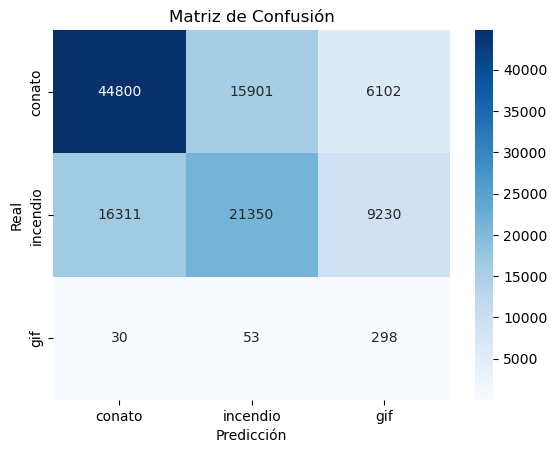

In [12]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Guardamos las etiquetas reales
etiquetas= ['conato', 'incendio', 'gif']

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas, yticklabels=etiquetas)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

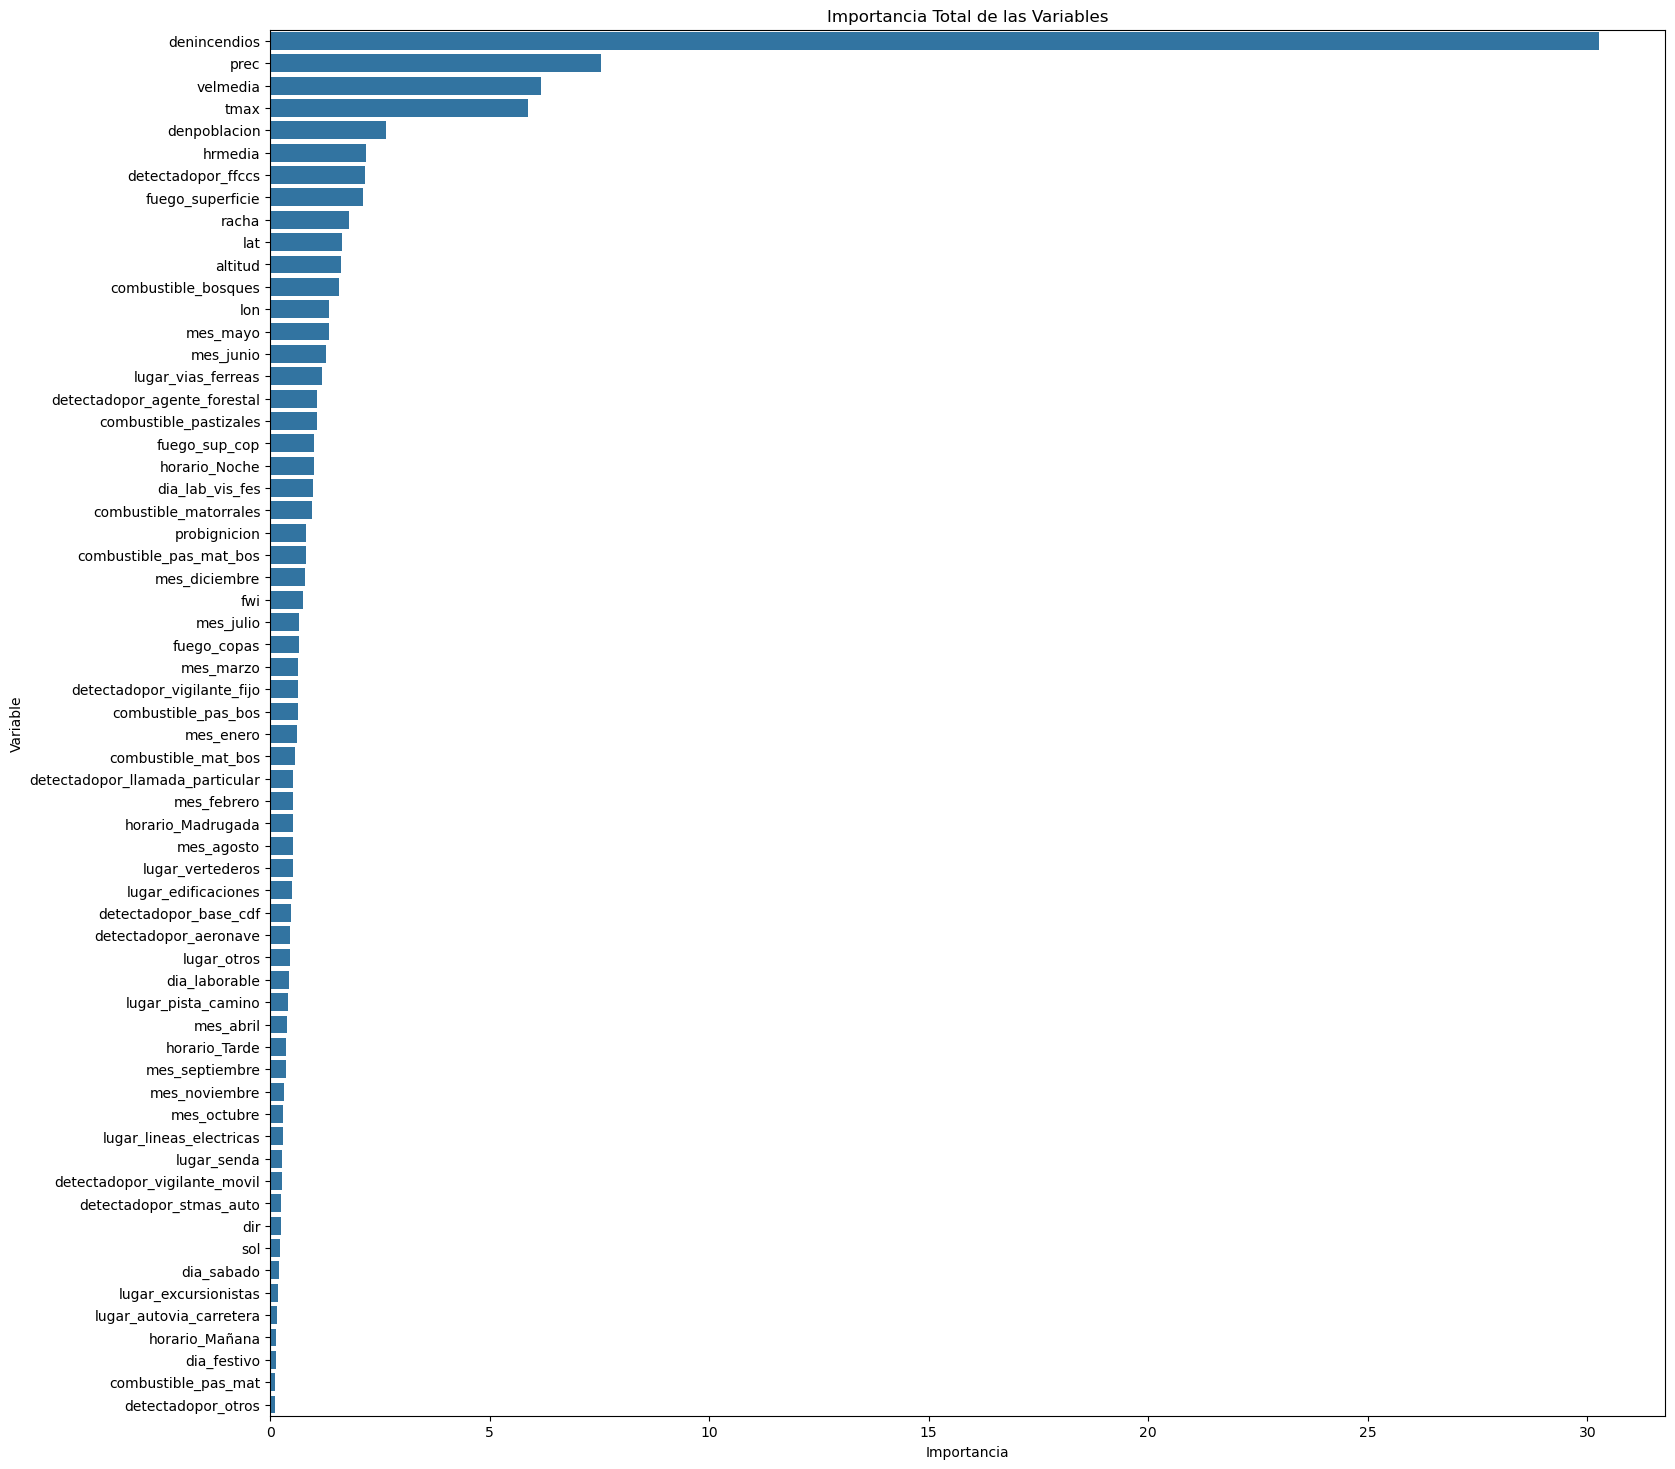

In [13]:
# Extraemos los coeficientes del modelo
coef = rlm.coef_  

# Lo pasamos a dataframe
importancia = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': abs(coef).sum(axis=0)
})

# Lo ordenamos
importancia = importancia.sort_values(by='Importancia', ascending=False)

# Mostramos el grafico por importancia de variables
plt.figure(figsize=(18, 18))
sns.barplot(x='Importancia', y='Variable', data=importancia)
plt.title("Importancia Total de las Variables")
plt.show()

In [15]:
# VAmos a seleccionar las caracteristicas que suman mas del 95% de importancia
# Suma del global 
total = importancia['Importancia'].sum()

# Lo ordenamos y vamos acumulando la suma de importancias
importancia = importancia.sort_values(by='Importancia', ascending=False)
importancia['Importancia Acumulada'] = importancia['Importancia'].cumsum()

# Seleccionamos las variables que sumen más del 95%
var_sel_rlm = importancia[importancia['Importancia Acumulada'] <= total * 0.95]

# Mostrar las variables seleccionadas
print(var_sel_rlm)

                           Variable  Importancia  Importancia Acumulada
13                     denincendios    30.258399              30.258399
4                              prec     7.527461              37.785860
7                          velmedia     6.160248              43.946108
5                              tmax     5.872773              49.818881
12                     denpoblacion     2.643473              52.462354
10                          hrmedia     2.175238              54.637592
17               detectadopor_ffccs     2.167193              56.804785
32                 fuego_superficie     2.106361              58.911146
8                             racha     1.786944              60.698090
3                               lat     1.644530              62.342620
1                           altitud     1.622587              63.965207
23              combustible_bosques     1.576944              65.542151
2                               lon     1.349501              66

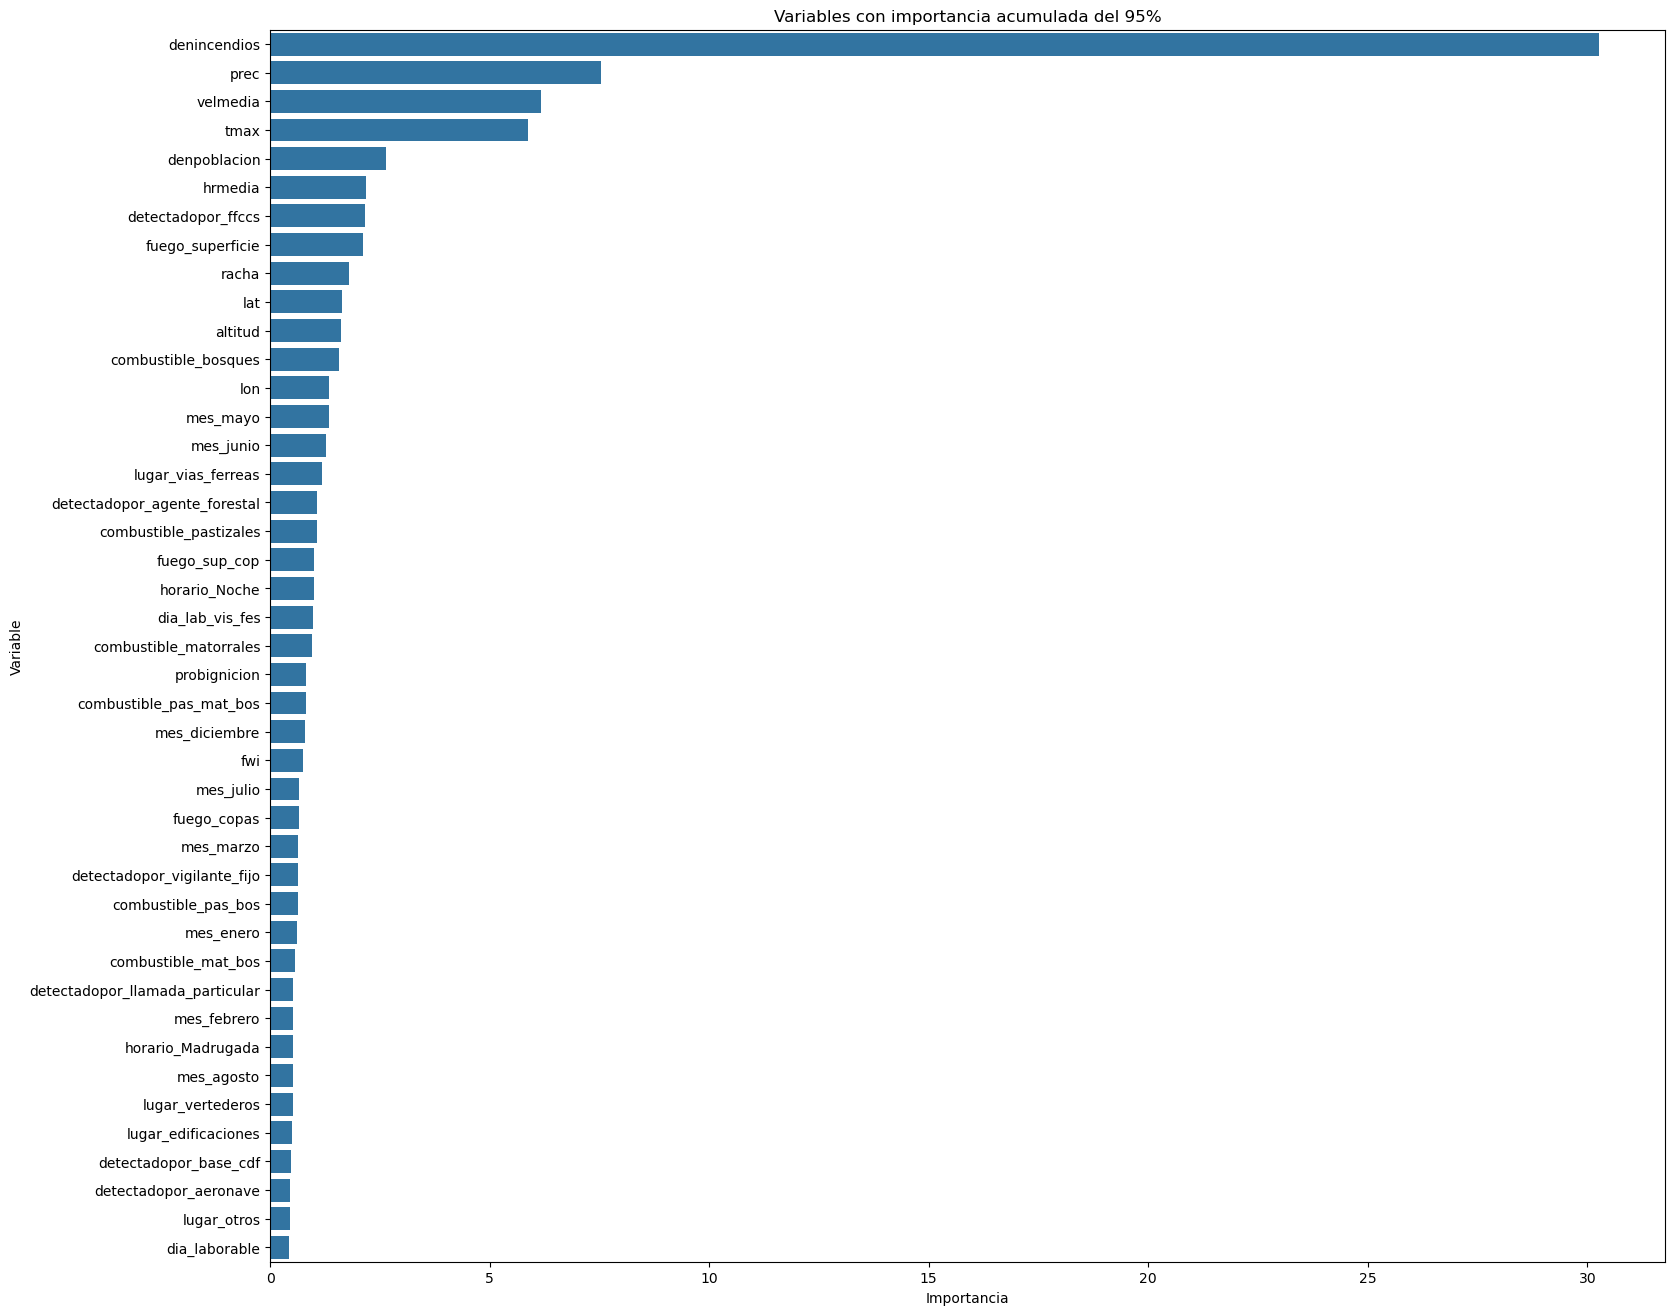

In [19]:
# Mostrar el gráfico de las variables seleccionadas
plt.figure(figsize=(18, 16))
sns.barplot(x='Importancia', y='Variable', data=var_sel_rlm)
plt.title("Variables con importancia acumulada del 95%")
plt.show()

### Selección de características con Random Forest

In [20]:
X = bdif.drop(['parte', 'año', 'fecha', 'cod_com', 'cod_prov', 'poblacion', 'superficie', 'areaquemada', 'claseincendio'], axis=1)
y = bdif['claseincendio']

In [21]:
# Dividimos en test y train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
# Entrenamos el modelo
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [23]:
# Hacer predicciones y evaluar el modelo
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.84      0.79     66843
           1       0.71      0.59      0.64     46839
           2       0.24      0.01      0.02       393

    accuracy                           0.73    114075
   macro avg       0.56      0.48      0.48    114075
weighted avg       0.73      0.73      0.73    114075



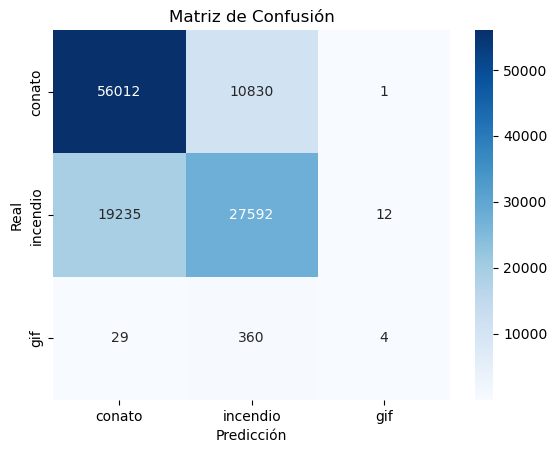

In [24]:
# Matriz de confusión con las clases ordenadas
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Guardamos las etiquetas reales
etiquetas= ['conato', 'incendio', 'gif']

# Creamos y mostramos la matriz mediante un mapa de calor
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas, yticklabels=etiquetas)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [25]:
# Importancia de las caracteristicas
importancia = rf.feature_importances_

# Lo pasamos a dataframe
importancia = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': importancia
})

# Las ordenamos
importancia = importancia.sort_values(by='Importancia', ascending=False)

# Las mostramos
print(importancia)

                   Variable   Importancia
13             denincendios  7.155232e-02
5                      tmax  6.411790e-02
12             denpoblacion  6.385823e-02
2                       lon  6.362303e-02
3                       lat  5.979801e-02
..                      ...           ...
14    detectadopor_aeronave  4.310996e-04
41       lugar_vias_ferreas  4.111511e-04
17       detectadopor_ffccs  1.990035e-05
16    detectadopor_base_cdf  3.320524e-06
20  detectadopor_stmas_auto  6.065675e-07

[62 rows x 2 columns]


In [26]:
# Suma del global 
total = importancia['Importancia'].sum()

# Lo ordenamos y vamos acumulando la suma de importancias
importancia = importancia.sort_values(by='Importancia', ascending=False)
importancia['Importancia Acumulada'] = importancia['Importancia'].cumsum()

# Seleccionamos las variables que sumen más del 95%
var_sel_rf = importancia[importancia['Importancia Acumulada'] <= total * 0.95]

# Mostrar las variables seleccionadas
print(var_sel_rf)

                           Variable  Importancia  Importancia Acumulada
13                     denincendios     0.071552               0.071552
5                              tmax     0.064118               0.135670
12                     denpoblacion     0.063858               0.199528
2                               lon     0.063623               0.263151
3                               lat     0.059798               0.322949
31                    fuego_sup_cop     0.055963               0.378912
11                              fwi     0.050447               0.429359
10                          hrmedia     0.048952               0.478311
1                           altitud     0.046653               0.524964
32                 fuego_superficie     0.045077               0.570041
9                               sol     0.045019               0.615060
8                             racha     0.043906               0.658966
6                               dir     0.042247               0

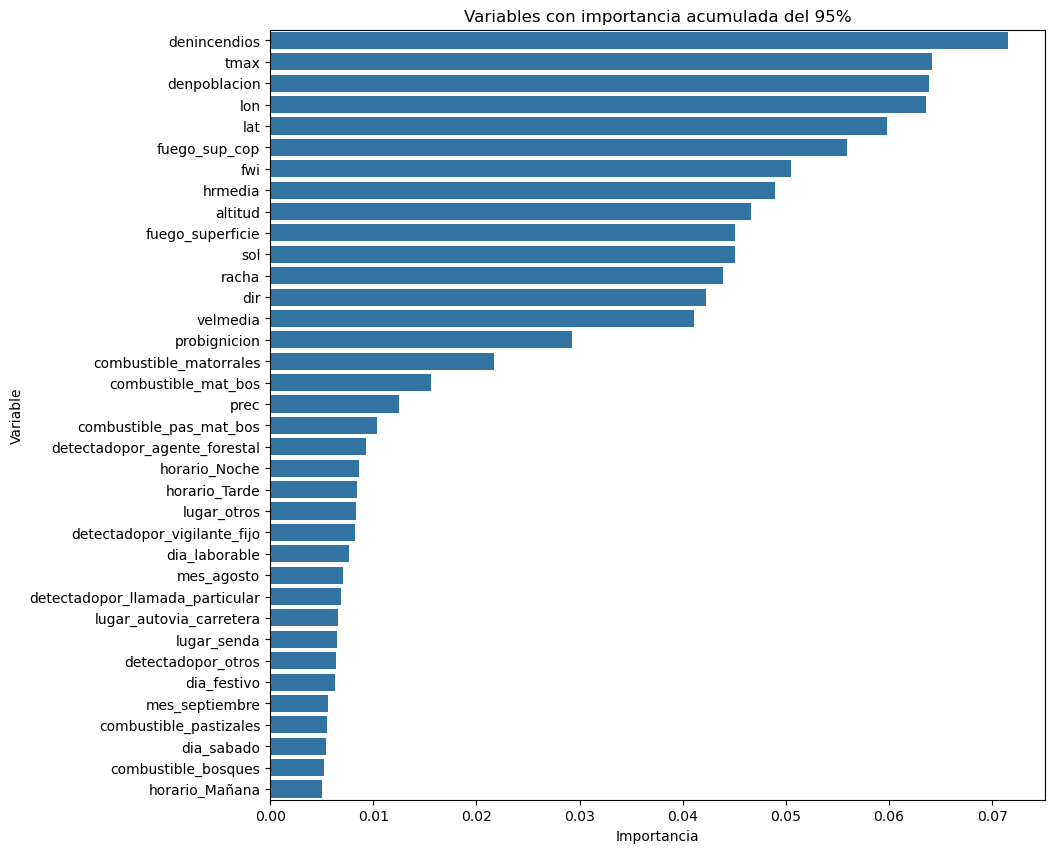

In [30]:
# Mostrar el gráfico de las variables seleccionadas
plt.figure(figsize=(10, 10))
sns.barplot(x='Importancia', y='Variable', data=var_sel_rf)
plt.title("Variables con importancia acumulada del 95%")
plt.show()

In [28]:
print(var_sel_rf['Variable'].to_list(), len(var_sel_rlm['Variable'].to_list()))

['denincendios', 'tmax', 'denpoblacion', 'lon', 'lat', 'fuego_sup_cop', 'fwi', 'hrmedia', 'altitud', 'fuego_superficie', 'sol', 'racha', 'dir', 'velmedia', 'probignicion', 'combustible_matorrales', 'combustible_mat_bos', 'prec', 'combustible_pas_mat_bos', 'detectadopor_agente_forestal', 'horario_Noche', 'horario_Tarde', 'lugar_otros', 'detectadopor_vigilante_fijo', 'dia_laborable', 'mes_agosto', 'detectadopor_llamada_particular', 'lugar_autovia_carretera', 'lugar_senda', 'detectadopor_otros', 'dia_festivo', 'mes_septiembre', 'combustible_pastizales', 'dia_sabado', 'combustible_bosques', 'horario_Mañana'] 43
